In [5]:
import os
import qutip as qt
from qutip import *
import numpy as np
from joblib import Parallel, delayed
from scipy.linalg import *
import os
import shutil
# from multiprocessing import Process
from pathlib import Path
from tqdm import tqdm
import pickle
import scipy.sparse as sps
import scipy.sparse.linalg as spsla

import importlib
import general_functions
# import sBs_noise_analysis
import plotsmodule
import metrology_noise
import bits
# import sBs
import backaction_noise
importlib.reload(general_functions)
# importlib.reload(sBs_noise_analysis)
importlib.reload(plotsmodule)
importlib.reload(metrology_noise)
importlib.reload(bits)
importlib.reload(backaction_noise)
# importlib.reload(sBs)
# from sBs import *
from general_functions import *
from plotsmodule import *
from metrology_noise import *
from bits import *
# from sBs_noise_analysis import *

In [6]:
cwd = os.getcwd()
path_QS = os.path.dirname(os.path.dirname(cwd))+ '/'
path_QS_noiseless = path_QS + 'Noiseless/'
path_QS_noiseless_data = path_QS_noiseless + 'Data/'
path_QS_noiseless_results = path_QS_noiseless_data + 'Results/'
path_QS_noise = path_QS + 'Noise/'
path_QS_noise_results = path_QS_noise + 'Results/'
path_QS_noise_results_backaction = path_QS_noise_results + 'backaction/'
path_QS_noise_results_eachnoise = path_QS_noise_results + 'eachnoise/'
path_QS_noise_results_exact = path_QS_noise_results + 'exact/'
path_QS_noise_results_states = path_QS_noise_results + 'Input_states/'
path_QS_noise_results_qorppath = path_QS_noise_results + 'q_or_p_bitstring_paths/'
path_QS_figures = path_QS + 'Figures/'
path_QS_figures_data = path_QS_figures + 'data/'

# Relaxation intuitive

## Simplest

In [7]:
import sBs
from sBs import *
Delta = 0.3
name = "sensor_state_delta-{0:.0f}-Nc140".format(Delta*100)
init_state_path = path_QS_noise_results_states + name
sensor = qu.qload(init_state_path)
ket_0 = qt.basis(2,1).full()
ket_1 = qt.basis(2,0).full()
P_ge_gg = qt.Qobj(ket_0 @ ket_1.T + ket_0 @ ket_0.T)
P_ge_gg = qu.tensor(qt.qeye(sensor.shape[0]),P_ge_gg ).full()

def sBs_q_relaxation(mu, Delta, beta):
    '''
    beta between 0 and 1 (not included)
    '''
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = -1j*l*cd, l*sd/2
    nu = (-1)**mu
    return CD(small)@I_Rx(-nu*np.pi/2)@ CD(beta * large) @ P_ge_gg  @CD((1-beta) * large)@I_Rx(np.pi/2)@CD(small)

beta = .01
Uq0_bf, Uq1_bf = sBs_q_relaxation(0, Delta, beta), sBs_q_relaxation(1, Delta, beta)
Kgq0_bf, Keq0_bf = Krauss_from_U(Uq0_bf)
Kgq1_bf, Keq1_bf = Krauss_from_U(Uq1_bf)

Krauss_dictionary, Krauss_dictionary_U = Krauss_dictionaries(Delta)
Kgq0, Keq0 = Krauss_dictionary_U['Kgq0'], Krauss_dictionary_U['Keq0']

# print(np.round(qt.Qobj(Kgq0-Keq0).eigenenergies(),3))

sensor = sensor.full()
rho_ok = qt.Qobj(Kgq0 @ sensor @ Kgq0.getH()+ Keq0 @ sensor @ Keq0.getH()) 
rho_bf = qt.Qobj(Kgq0_bf @ sensor @ Kgq0_bf.getH() + Keq0_bf @ sensor @ Keq0_bf.getH())
rho_ok = rho_ok/ rho_ok.tr()
rho_bf = rho_bf/ rho_bf.tr()
print('fidelity:', qt.fidelity(qt.Qobj(rho_ok), qt.Qobj(rho_bf)))

xvec = np.arange(-2*l, 2*l, 0.05)
W_ok = qt.wigner(qt.Qobj(rho_ok), xvec, xvec)
W_bf = qt.wigner(qt.Qobj(rho_bf), xvec, xvec)

/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


fidelity: 0.9907597377221254


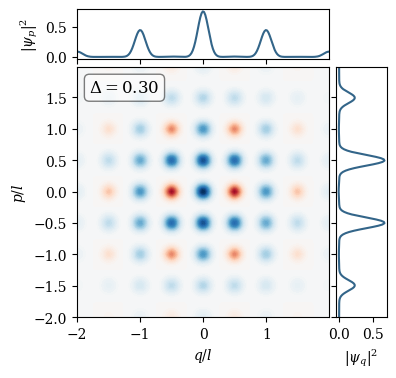

In [8]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W_ok, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W_ok, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W_ok.max(), W_ok.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W_ok, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

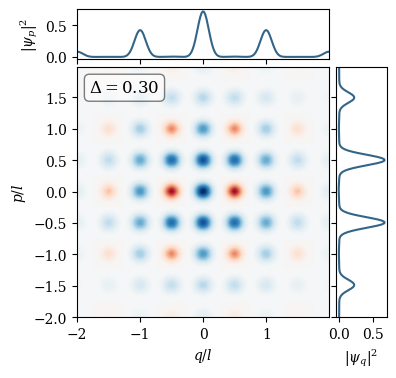

In [9]:
# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W_bf, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W_bf, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W_bf.max(), W_bf.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W_bf, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
Delta = 0.3
textstr = r'$\Delta = {0:.2f}$'.format(Delta)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

## Relaxation at all beta

In [10]:
def sBs_q_relaxation(mu, Delta, beta):
    '''
    beta between 0 and 1 (not included)
    '''
    sd, cd, td = np.sinh(Delta**2), np.cosh(Delta**2), np.tanh(Delta**2)
    large, small = -1j*l*cd, l*sd/2
    nu = (-1)**mu
    return CD(small)@I_Rx(-nu*np.pi/2)@ CD(beta * large) @ P_ge_gg  @CD((1-beta) * large)@I_Rx(np.pi/2)@CD(small)

def fidelity_after_relaxation(sensor, Delta,beta):
    
    Uq0_bf, Uq1_bf = sBs_q_relaxation(0, Delta,beta), sBs_q_relaxation(1, Delta,beta)
    Kgq0_bf, Keq0_bf = Krauss_from_U(Uq0_bf)
    Kgq1_bf, Keq1_bf = Krauss_from_U(Uq1_bf)

    Krauss_dictionary, Krauss_dictionary_U = Krauss_dictionaries(Delta)
    Kgq0, Keq0 = Krauss_dictionary_U['Kgq0'], Krauss_dictionary_U['Keq0']

    # print(np.round(qt.Qobj(Kgq0-Keq0).eigenenergies(),3))

    rho_ok_g = qt.Qobj(Kgq0 @ sensor @ Kgq0.getH())
    rho_ok_e = qt.Qobj(Keq0 @ sensor @ Keq0.getH())
    rho_bf_g = qt.Qobj(Kgq0_bf @ sensor @ Kgq0_bf.getH())
    rho_ok_g = rho_ok_g/ rho_ok_g.tr()
    rho_ok_e = rho_ok_e/ rho_ok_e.tr()
    rho_bf_g = rho_bf_g/ rho_bf_g.tr()

    F_gg = qt.fidelity(qt.Qobj(rho_ok_g), qt.Qobj(rho_bf_g))
    F_eg = qt.fidelity(qt.Qobj(rho_ok_e), qt.Qobj(rho_bf_g))
    F_bf_gg = qt.fidelity(qt.Qobj(rho_bf_g), qt.Qobj(rho_bf_g))
    return [F_gg, F_eg,F_bf_gg]

beta_range = np.linspace(0, 1, 50)
fidelities = [fidelity_after_relaxation(sensor, Delta, beta) for beta in tqdm(beta_range)]


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:51<00:00,  2.22s/it]


(50, 3)


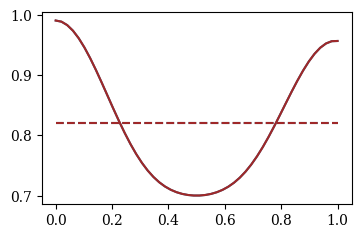

In [11]:
fig, ax = plt.subplots(figsize=(4, 2.5))
fidelities = np.array(fidelities)
print(fidelities.shape)
F_gg = fidelities[:, 0]
F_eg = fidelities[:, 1]
F_bf_gg = fidelities[:, 2]
ax.plot(beta_range, F_gg, color=blue)
ax.plot(beta_range, F_eg, color=red)
# ax.plot(beta_range, F_bf_gg, color=green, linestyle='--', label='ok ge')
# ax.plot(beta_range, F_bf_gg, color=blue, linestyle='--', label='bitflip gg')
ax.plot(beta_range, np.average(F_gg)*np.ones_like(beta_range), color=blue, linestyle='--', label='average fidelity')
ax.plot(beta_range, np.average(F_eg)*np.ones_like(beta_range), color=red, linestyle='--')
# ax.plot(beta_range, np.average(F_bf_gg)*np.ones_like(beta_range), color=light_blue, linestyle='--')

dict_figure = {}
dict_figure['fidelities'] = fidelities
dict_figure['beta_range'] = beta_range
name = 'data-relaxation-qubit'
np.savez(path_QS_figures_data+name, **dict_figure)
